# Implementación

### Dependencias

Para una correcta ejecución del código se deduce que se tiene instalado <kbd>python3</kbd> y <kbd>jupyter-notebook</kbd> (con las dependencias que estas implican), además se requiere que estén instalados los siguientes paquetes:

-   <kbd>scikit-image</kbd>: Procesamiento de imágenes en Python
-   <kbd>numpy</kbd>: Procesamiento de matrices para números, cadenas, registros y objetos en Python
-   <kbd>matplotlib</kbd>: Biblioteca de gráficos de Python

Además debe de encontrarse la carpeta <kbd>images</kbd> en el mismo directorio que el archivo **.ipynb*

### Preparándose

Comenzamos importando las bibliotecas requeridas con el siguiente bloque de código:

In [5]:
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.ndimage.measurements import label, find_objects 
from scipy.ndimage.morphology import binary_erosion
from skimage.morphology import reconstruction, binary_opening, reconstruction
from scipy.ndimage import median_filter
import numpy as np
import matplotlib.pylab as plt
import cv2 as cv

### Función para *remover objetos grandes*

A continuación está el código de la función desarrollada para la eliminación de objetos grandes definiendo un tamaño de como umbral, nótese que las variables al igual que la información de la función están en inglés, solo los comentarios sobre las sentencias o ciclos que así lo requieran están en español.

In [2]:
def remove_big_objects(image, objSize):
    ''' Remove objects biger than the specified size
    ## Parameters
    ----------
    image : ndarray
        Binary image
    objSize : int
        Size of objects to remove

    ## Returns
    -------
    img_array : ndarray
        Image with small connected components removed.
    '''
    # Etiquetamos los objetos de la imagen
    a, b = label(image, structure=np.ones((3,3)))
    # Creamos la imagen de salida, haciendo una copia con el arreglo de los objetos etiquetados.
    outImage = np.copy(a)
    # Obtenemos las dimensiones de los objetos
    objects = find_objects(a)
    # Inicializamos i para establecer la etiqueta de los objetos grandes
    i = 1
    # Creamos un arreglo vacio para guardara las etiquetas de los objetos grandes
    max_objects = []
    # Identificamos las etiquetas de los objetos grandes de la imagen
    for s1,s2 in objects:
        # Se considera a un objeto grande si su dimensión excede el tamaño establecido en el parametro objSize
        if ((s1.stop - s1.start) >= objSize or (s2.stop - s2.start) >= objSize):
            # Agregamos el objeto grande al arreglo antes creado
            max_objects.append(int(i))
        # Incrementamos i que nos permite identificar la etiqueta del objeto grande
        i+=1

    # Eliminamos los objetos grandes de la imagen de salida

    for i in max_objects:
        outImage[outImage == i] = 0

    outImage[outImage > 0] = 255

    return outImage.astype(np.bool8)

### Prueba
Dentro de la carpeta <kbd>images</kbd> se encuentran tres imágenes para realizar las pruebas, se hará solo uso de una, para probar con las demás solo cambie __*xx.jpg__  por *01.jpg*, *02.jpg* o *03.jpg*. Al finalizar la ejecucíon de este bloque de código se mostrara el total del celulas que son identificadas en la imagen.

In [14]:
# Definimos el elemento estructural (circulo) para las operaciones a realizar
st = np.array([[0, 1, 1, 0], [1, 1, 1, 1], [1, 1, 1, 1], [0, 1, 1, 0]])
# Leemos la imagen a color que será procesada, cambiar el *xx.jpg por 01, 02 o 03
im_color = imread('images/A00_03.jpg')
# Convertimos la imagen a escala de grises
im_gray = rgb2gray(im_color)
# Aplicamos un filtro de mediana para poder eliminar las membranas de las celulas al momento de binarizar la imagen
im_gray = median_filter(im_gray, size = 9)
# Binarizamos la imagen, el umbral funciona para el set de imagenes a utilizar 
im_binary = (im_gray > 0.28).astype(np.uint8)
# Invertimos la imagen
im_binary = 1 - im_binary
# Creamos una mascara que sera sometida a una operación de apertura, que nos permitira mantener los nucleos de las celulas
mask = binary_opening(im_binary, selem=st)
# Creamos la semilla de los objetos que nos interesan (nucleos de las celulas) erosionando la imagen 
seed = binary_erosion(im_binary, structure=st, iterations=2)
# Reconstruimos la imagen dilatando el nucleo de la celulas correspondientes a las semilla en la mascara
cell = reconstruction(seed, mask, 'dilation')
# Elimnamos objetos de gran tamaño que pueden ser mantenidos por las operaciones anteriores
cell_new = remove_big_objects(cell, 60)
# Utilizamos label para contar el número de celulas (nucleos) de la imagen
a, number_cells = label(cell_new, structure=np.ones((3,3)))
# Imprimirmos el numero de celulas de la imagen 
print("Number of cells:", number_cells)
# Creamos una copia de la imagen a color para no modificar la original
cell_color = np.copy(im_color)
# Resaltamos los nucleos en color verde de las celulas en la imagen a color
cell_color[...,0][np.bool8(cell_new) == True] = 0
cell_color[...,1][np.bool8(cell_new) == True] = 255
cell_color[...,2][np.bool8(cell_new) == True] = 0

Number of cells: 1031


Mostramos las imagenes releventaes, si desea apreciar mejor las imagnes se recomienda modificar el parametro *figsize* de la figura. Si lo requiere puede cambiar las imagenes a mostrar por: *im_color*, *im_gray*, *im_binary*, *mask*, *seed*, *cell*, *cell_new*, *cell_color*, que son las generadas durante la ejecución del bloque de código anterior.

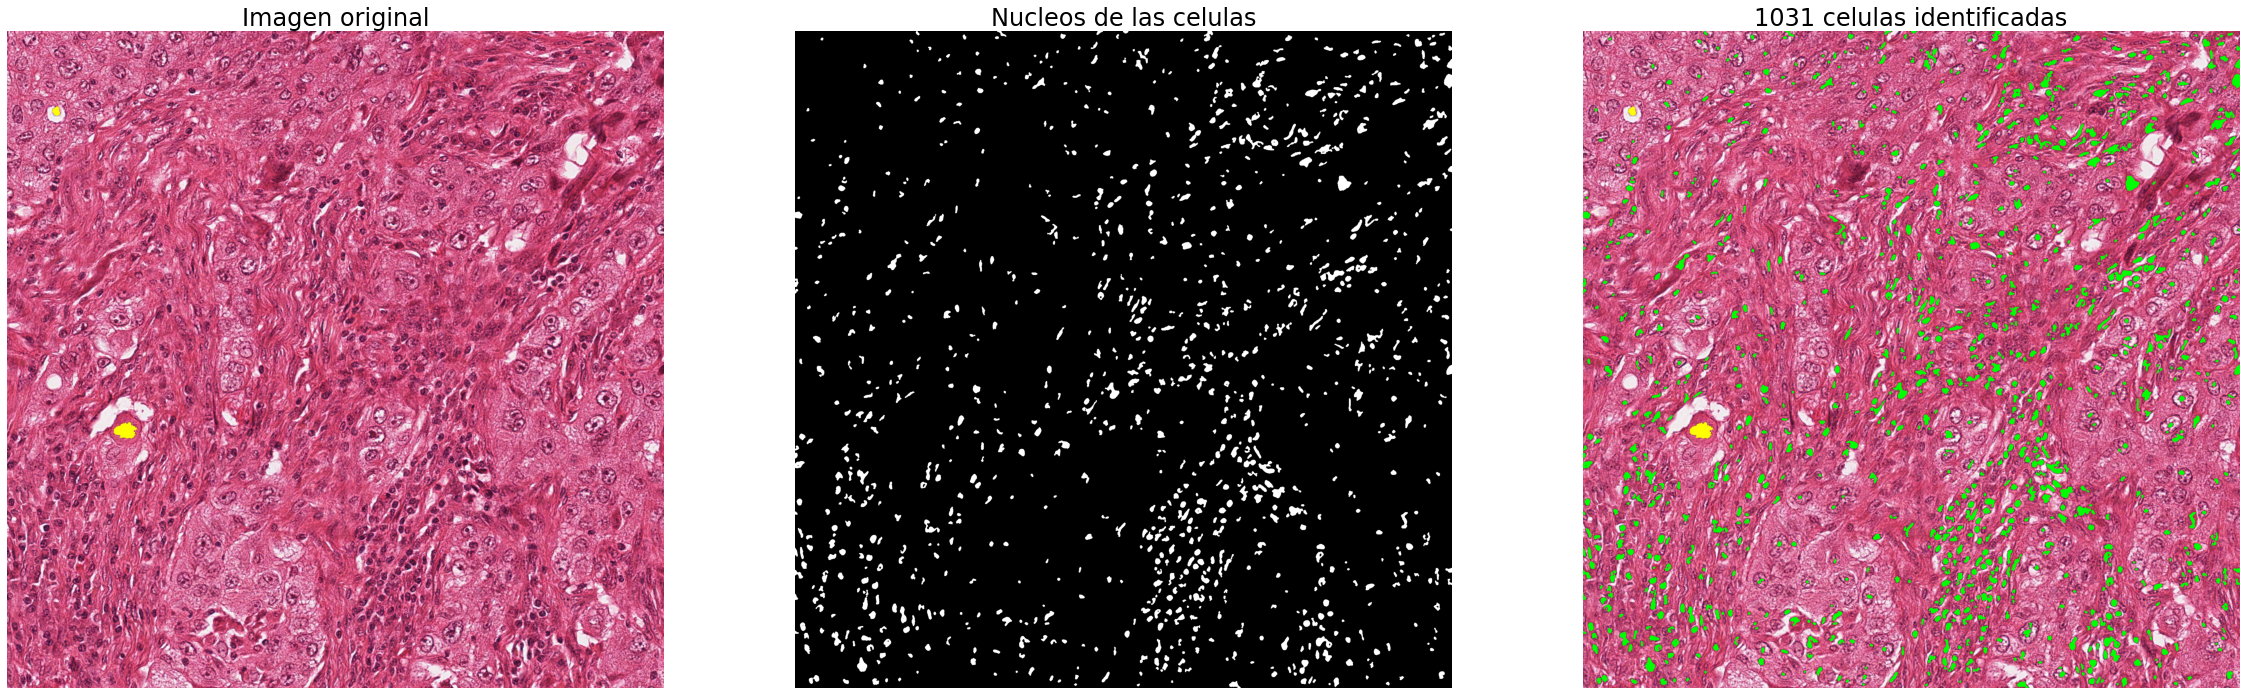

True

In [15]:
# Mostramos en una figura las imagenes relevantes del proceso
plt.figure(figsize=(40,20))
plt.subplot(131), plt.imshow(im_color), plt.axis('off'), plt.title('Imagen original', size=24)
plt.subplot(132), plt.imshow(cell_new, cmap="gray"), plt.axis('off'), plt.title('Nucleos de las celulas', size=24)
plt.subplot(133), plt.imshow(cell_color), plt.axis('off'), plt.title(str(number_cells) + ' celulas identificadas', size=24)
plt.show()
cv.imwrite(r'C:\Users\Usuario\Documents\Img3.jpg', cell_color)